# Air Quality Index Analysis

# Plan:
- Gathering air quality data from various sources, such as government monitoring stations, sensors, or satellite imagery.
- Cleaning and preprocessing the collected data.
- Calculating the Air Quality Index using standardized formulas and guidelines provided by environmental agencies.
- Creating visualizations, such as line charts or heatmaps, to represent the AQI over time or across geographical regions.
- Comparing the AQI metrics of the location with the recommended air quality metrics.

In [4]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "plotly_white"

data = pd.read_csv("/Users/Илья/Downloads/delhiaqi.csv")
data.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19


In [5]:
data['date'] = pd.to_datetime(data['date'])

Let’s have a look at the descriptive statistics of the data:

In [6]:
data.describe()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,3814.942210,51.181979,75.292496,30.141943,64.655936,358.256364,420.988414,26.425062
std,3227.744681,83.904476,42.473791,39.979405,61.073080,227.359117,271.287026,36.563094
min,654.220000,0.000000,13.370000,0.000000,5.250000,60.100000,69.080000,0.630000
25%,1708.980000,3.380000,44.550000,0.070000,28.130000,204.450000,240.900000,8.230000
50%,2590.180000,13.300000,63.750000,11.800000,47.210000,301.170000,340.900000,14.820000
75%,4432.680000,59.010000,97.330000,47.210000,77.250000,416.650000,482.570000,26.350000
max,16876.220000,425.580000,263.210000,164.510000,511.170000,1310.200000,1499.270000,267.510000


Now let’s have a look at the intensity of each pollutant over time in the air quality:

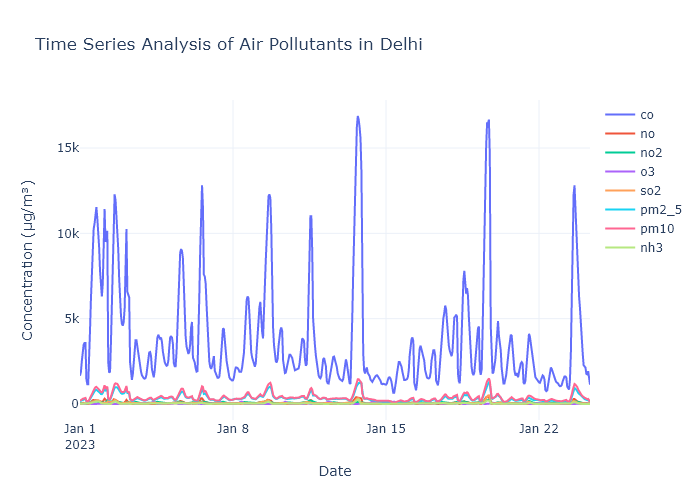

In [8]:
# time series plot for each air pollutant
fig = go.Figure()

for pollutant in ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']:
    fig.add_trace(go.Scatter(x=data['date'], y=data[pollutant], mode='lines', 
                             name=pollutant))

fig.update_layout(title='Time Series Analysis of Air Pollutants in Delhi',
                  xaxis_title='Date', yaxis_title='Concentration (µg/m³)')
fig.show(renderer='png')

## Calculating Air Quality Index

Now, before moving forward, we need to calculate the air quality index and its category. AQI is typically computed based on the concentration of various pollutants, and each pollutant has its sub-index:

In [9]:
# Define AQI breakpoints and corresponding AQI values
aqi_breakpoints = [
    (0, 12.0, 50), (12.1, 35.4, 100), (35.5, 55.4, 150),
    (55.5, 150.4, 200), (150.5, 250.4, 300), (250.5, 350.4, 400),
    (350.5, 500.4, 500)
]

def calculate_aqi(pollutant_name, concentration):
    for low, high, aqi in aqi_breakpoints:
        if low <= concentration <= high:
            return aqi
    return None

def calculate_overall_aqi(row):
    aqi_values = []
    pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
    for pollutant in pollutants:
        aqi = calculate_aqi(pollutant, row[pollutant])
        if aqi is not None:
            aqi_values.append(aqi)
    return max(aqi_values)

# Calculate AQI for each row
data['AQI'] = data.apply(calculate_overall_aqi, axis=1)

# Define AQI categories
aqi_categories = [
    (0, 50, 'Good'), (51, 100, 'Moderate'), (101, 150, 'Unhealthy for Sensitive Groups'),
    (151, 200, 'Unhealthy'), (201, 300, 'Very Unhealthy'), (301, 500, 'Hazardous')
]

def categorize_aqi(aqi_value):
    for low, high, category in aqi_categories:
        if low <= aqi_value <= high:
            return category
    return None

# Categorize AQI
data['AQI Category'] = data['AQI'].apply(categorize_aqi)
data.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,AQI,AQI Category
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83,300,Very Unhealthy
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66,300,Very Unhealthy
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40,400,Hazardous
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55,400,Hazardous
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19,400,Hazardous


In the above code we are defining two functions:
- `calculate_aqi`: to calculate the AQI for a specific pollutant and concentration by finding the appropriate range in the aqi_breakpoints
- `calculate_overall_aqi`: to calculate the overall AQI for a row in the dataset by considering the maximum AQI value among all pollutants

## Analyzing AQI of Delhi

Let’s have a look at the AQI of Delhi in January:

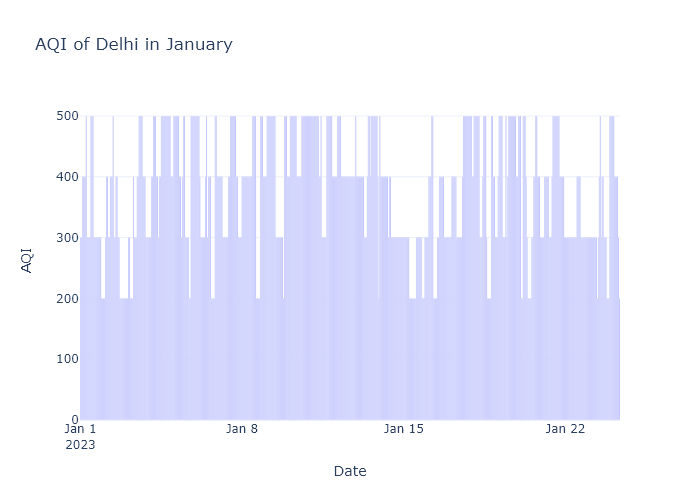

In [11]:
# AQI over time
fig = px.bar(data, x="date", y="AQI", 
             title="AQI of Delhi in January")
fig.update_xaxes(title="Date")
fig.update_yaxes(title="AQI")
fig.show(renderer='png')

Now, let’s have a look at the AQI category distribution:

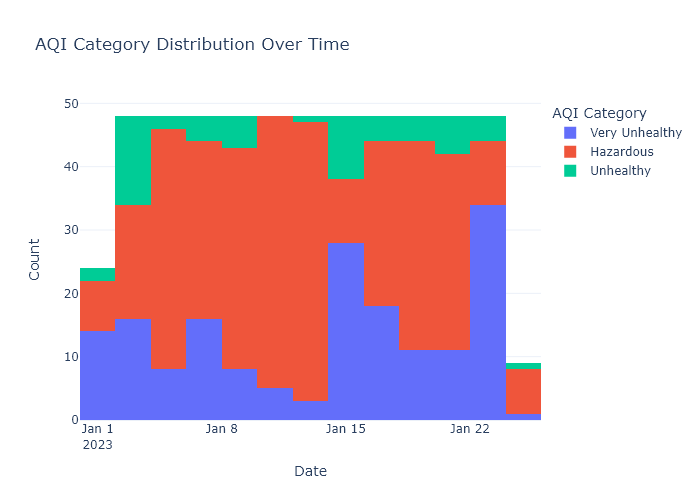

In [12]:
fig = px.histogram(data, x="date", 
                    color="AQI Category", 
                    title="AQI Category Distribution Over Time")
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Count")
fig.show(renderer='png')

Let’s have a look at the distribution of pollutants in the air quality of Delhi:

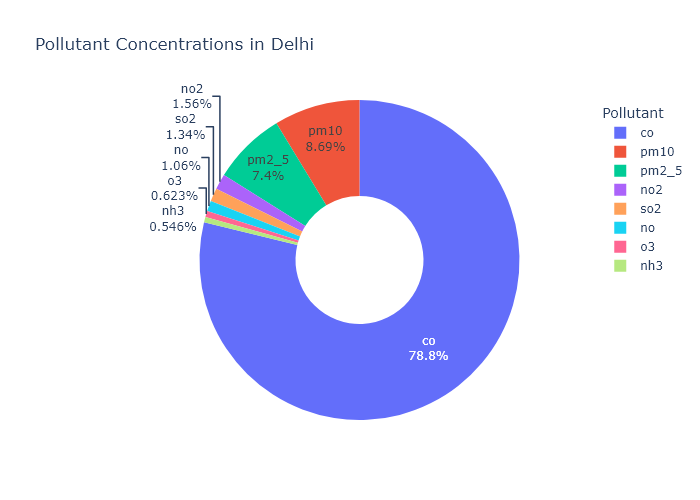

In [13]:
# Define pollutants and their colors
pollutants = ["co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]
pollutant_colors = px.colors.qualitative.Plotly

# Calculate the sum of pollutant concentrations
total_concentrations = data[pollutants].sum()

# Create a DataFrame for the concentrations
concentration_data = pd.DataFrame({
    "Pollutant": pollutants,
    "Concentration": total_concentrations
})

# Create a donut plot for pollutant concentrations
fig = px.pie(concentration_data, names="Pollutant", values="Concentration",
             title="Pollutant Concentrations in Delhi",
             hole=0.4, color_discrete_sequence=pollutant_colors)

# Update layout for the donut plot
fig.update_traces(textinfo="percent+label")
fig.update_layout(legend_title="Pollutant")

# Show the donut plot
fig.show(renderer='png')

Now, let’s have a look at the correlation between pollutants:

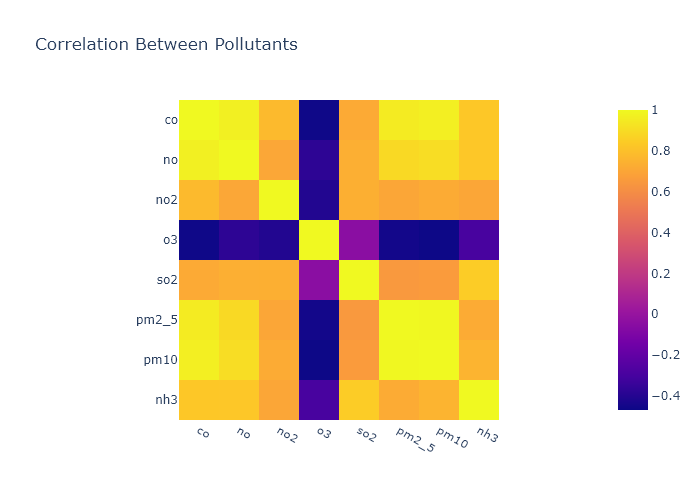

In [14]:
# Correlation Between Pollutants
correlation_matrix = data[pollutants].corr()
fig = px.imshow(correlation_matrix, x=pollutants, 
                 y=pollutants, title="Correlation Between Pollutants")
fig.show(renderer='png')

Overall, the positive correlations among CO, NO, NO2, SO2, PM2.5, PM10, and NH3 suggest that they may share common sources or have similar pollution patterns, while O3 exhibits an inverse relationship with the other pollutants, which may be due to its role as both a pollutant and a natural atmospheric oxidant.

Let’s have a look at the hourly average trends of AQI in Delhi:

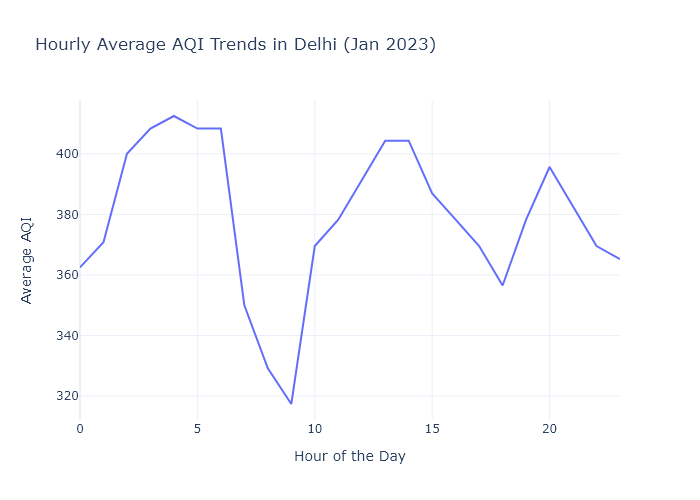

In [15]:
# Extract the hour from the date
data['Hour'] = pd.to_datetime(data['date']).dt.hour

# Calculate hourly average AQI
hourly_avg_aqi = data.groupby('Hour')['AQI'].mean().reset_index()

# Create a line plot for hourly trends in AQI
fig = px.line(hourly_avg_aqi, x='Hour', y='AQI', 
              title='Hourly Average AQI Trends in Delhi (Jan 2023)')
fig.update_xaxes(title="Hour of the Day")
fig.update_yaxes(title="Average AQI")
fig.show(renderer='png')

Now, let’s have a look at the average AQI by day of the week in Delhi:

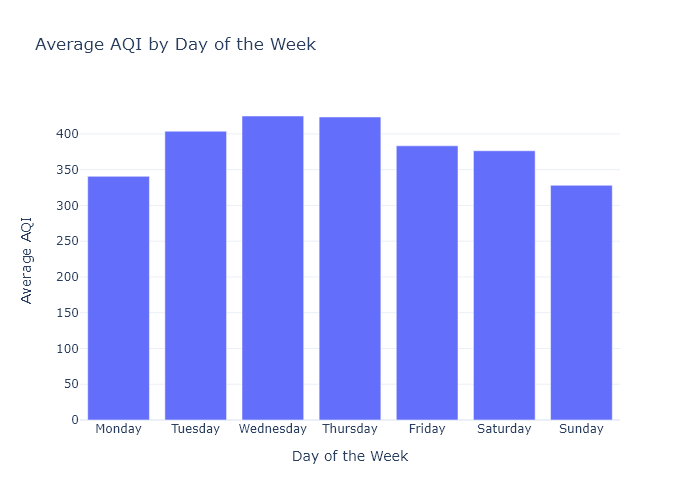

In [16]:
# Average AQI by Day of the Week
data['Day_of_Week'] = data['date'].dt.day_name()
average_aqi_by_day = data.groupby('Day_of_Week')['AQI'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
fig = px.bar(average_aqi_by_day, x=average_aqi_by_day.index, y='AQI', 
              title='Average AQI by Day of the Week')
fig.update_xaxes(title="Day of the Week")
fig.update_yaxes(title="Average AQI")
fig.show(renderer='png')

It shows that the air quality in Delhi is worse on Wednesdays and Thursdays.